### Loading necessary libraries

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2

import joblib

### Defining files' path

In [4]:
os.getcwd()

'C:\\Users\\jocl0\\Project1\\notebook'

In [5]:
data_dir = 'C:\\Users\\jocl0\\Project1\\data\\'
model_dir = 'C:\\Users\\jocl0\\Project1\\notebook\\'

dir_ = os.listdir(data_dir)

model_file = model_dir + 'CNN.joblib'

In [6]:
dir_

['images2predict', 'test', 'train', 'valid']

### Retrieving directories list

In [8]:
all_dir = dict.fromkeys(dir_)

for d in dir_ :
    all_dir[d] = glob.glob(data_dir+d+'/*')

### Retrieving data files

In [10]:
files = dict.fromkeys(dir_)

for key in dict.fromkeys(dir_) :
    files[key] = []
    
    for d in range(len(all_dir[key])) :

        if key != 'images2predict' :
            files[key].extend(glob.glob(all_dir[key][d]+'/*.jpg'))
        else :
            files[key].append(all_dir[key][d])


### Investigate dataset resolution distribution

### Defining the image resolution

In [13]:
res = (224, 224)

### Image Augmentation and Scaling

In [71]:
img_gen = ImageDataGenerator(rescale=1./255)

img_gen_train = ImageDataGenerator(rescale=1./255, #,
                                   rotation_range=10, #20,
                                   width_shift_range=0.1, #0.2,
                                   height_shift_range=0.1, #0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.1, #) #0.2)
                                   brightness_range=[0.8,1.2],  
                                   fill_mode='nearest')


### Apply Image augmentation and scaling to dataset

In [73]:
train_data = img_gen_train.flow_from_directory(data_dir+'train',
                                               target_size=res, 
                                               batch_size=32, 
                                               class_mode='categorical',
                                               shuffle=True)

train_data.class_indices

Found 3208 images belonging to 20 classes.


{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'AFRICAN PYGMY GOOSE': 8,
 'ALBATROSS': 9,
 'ALBERTS TOWHEE': 10,
 'ALEXANDRINE PARAKEET': 11,
 'ALPINE CHOUGH': 12,
 'ALTAMIRA YELLOWTHROAT': 13,
 'AMERICAN AVOCET': 14,
 'AMERICAN BITTERN': 15,
 'AMERICAN COOT': 16,
 'AMERICAN FLAMINGO': 17,
 'AMERICAN GOLDFINCH': 18,
 'AMERICAN KESTREL': 19}

In [137]:
val_data = img_gen.flow_from_directory(data_dir+'test',
                                       target_size=res, 
                                       batch_size=1, 
                                       shuffle=False,
                                       class_mode='categorical')

val_data.class_indices

Found 100 images belonging to 20 classes.


{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'AFRICAN PYGMY GOOSE': 8,
 'ALBATROSS': 9,
 'ALBERTS TOWHEE': 10,
 'ALEXANDRINE PARAKEET': 11,
 'ALPINE CHOUGH': 12,
 'ALTAMIRA YELLOWTHROAT': 13,
 'AMERICAN AVOCET': 14,
 'AMERICAN BITTERN': 15,
 'AMERICAN COOT': 16,
 'AMERICAN FLAMINGO': 17,
 'AMERICAN GOLDFINCH': 18,
 'AMERICAN KESTREL': 19}

In [19]:
test_data = img_gen.flow_from_directory(data_dir+'valid',
                                       target_size=res, 
                                       batch_size=1, 
                                       shuffle=False,
                                       class_mode='categorical')

test_data.class_indices

Found 100 images belonging to 20 classes.


{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'AFRICAN PYGMY GOOSE': 8,
 'ALBATROSS': 9,
 'ALBERTS TOWHEE': 10,
 'ALEXANDRINE PARAKEET': 11,
 'ALPINE CHOUGH': 12,
 'ALTAMIRA YELLOWTHROAT': 13,
 'AMERICAN AVOCET': 14,
 'AMERICAN BITTERN': 15,
 'AMERICAN COOT': 16,
 'AMERICAN FLAMINGO': 17,
 'AMERICAN GOLDFINCH': 18,
 'AMERICAN KESTREL': 19}

In [20]:
pred_data = img_gen.flow_from_directory(data_dir+'images2predict',
                                       target_size=res, 
                                       batch_size=1, 
                                       shuffle=False,
                                       class_mode=None)

pred_data.class_indices

Found 6 images belonging to 1 classes.


{'dum': 0}

### Load model if it already exists

In [22]:
if os.path.exists(model_file) :
    cnn = joblib.load('../model/CNN.joblib')
    img_gen = joblib.load('../model/CNN_img_gen.joblib')
    print('Model exists')

### Define model if it does not already exist

In [75]:
if True :#not os.path.exists(model_file) :
    print('Model does not exists')

    cnn = Sequential()
    
    cnn.add(Conv2D(filters=8,kernel_size=(10,10), padding='valid', activation='relu' ,input_shape=(res[0],res[1],3)))#, kernel_regularizer=l2(0.001))
    #cnn.add(BatchNormalization())
    #cnn.add(Activation('relu'))
    #cnn.add(MaxPool2D(pool_size=(2,2)))#, strides=2))

    cnn.add(Conv2D(filters=16,kernel_size=(7,7), padding='same', activation='relu'))#, kernel_regularizer=l2(0.001))
    #cnn.add(BatchNormalization())
    #cnn.add(Activation('relu'))
    #cnn.add(MaxPool2D(pool_size=(2,2)))#, strides=2))

    cnn.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))#, kernel_regularizer=l2(0.001))
    cnn.add(MaxPool2D(pool_size=(2,2)))
    #cnn.add(BatchNormalization())
    #cnn.add(Activation('relu'))

    #cnn.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))#, kernel_regularizer=l2(0.001))
    #cnn.add(BatchNormalization())
    
    cnn.add(Conv2D(filters=64, kernel_size=(3,3),  padding='same', activation='relu'))#, kernel_regularizer=l2(0.001))
    #cnn.add(BatchNormalization())
    #cnn.add(Activation('relu'))
    cnn.add(MaxPool2D(pool_size=(2,2)))#, strides=2))

    cnn.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same', activation='relu'))#, kernel_regularizer=l2(0.001))
    #cnn.add(BatchNormalization())
    #cnn.add(Activation('relu'))
    cnn.add(MaxPool2D(pool_size=(2,2))) #, strides=2))

    cnn.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu',  padding='same'))#, kernel_regularizer=l2(0.001)))
    #cnn.add(BatchNormalization())
    #cnn.add(Activation('relu'))
    cnn.add(MaxPool2D(pool_size=(2,2)))#, strides=2))

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))

    cnn.add(Dropout(rate= 0.3)) #0.2

    cnn.add(Dense(units=len(train_data.class_indices), activation='softmax'))

    cnn.compile(optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'],loss='categorical_crossentropy') #Adam(learning_rate=0.0005) 'adam'
    # cnn.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    

Model does not exists


### Print model summary

In [77]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 215, 215, 8)       2408      
                                                                 
 conv2d_7 (Conv2D)           (None, 215, 215, 16)      6288      
                                                                 
 conv2d_8 (Conv2D)           (None, 215, 215, 32)      12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 107, 107, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                  

### Train the model on the dataset

In [79]:
#early_stop = EarlyStopping(monitor='val_loss', patience = 5)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


cnn.fit(train_data, epochs=100, validation_data=test_data, callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
101/101 [==============================] - 194s 2s/step - loss: 2.9899 - accuracy: 0.0627 - val_loss: 2.9725 - val_accuracy: 0.0700 - lr: 1.0000e-04
Epoch 2/100
101/101 [==============================] - 191s 2s/step - loss: 2.8536 - accuracy: 0.1004 - val_loss: 2.6290 - val_accuracy: 0.1400 - lr: 1.0000e-04
Epoch 3/100
101/101 [==============================] - 192s 2s/step - loss: 2.6442 - accuracy: 0.1833 - val_loss: 2.4159 - val_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 4/100
101/101 [==============================] - 209s 2s/step - loss: 2.4748 - accuracy: 0.2394 - val_loss: 2.2497 - val_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 5/100
101/101 [==============================] - 213s 2s/step - loss: 2.3599 - accuracy: 0.2578 - val_loss: 2.0834 - val_accuracy: 0.3700 - lr: 1.0000e-04
Epoch 6/100
101/101 [==============================] - 205s 2s/step - loss: 2.2245 - accuracy: 0.3176 - val_loss: 1.9806 - val_accuracy: 0.3900 - lr: 1.0000e-04
Epoch 7/100
101/101 [=============

### Save model

In [89]:
#joblib.dump(cnn, "C:\\Users\\jocl0\\Project1\\model\\CNN_aug_wonder.joblib")
cnn.save("C:\\Users\\jocl0\\Project1\\model\\CNN_aug_wonder.keras")
#joblib.dump(img_gen_train, "C:\\Users\\jocl0\\Project1\\model\\CNN_img_gen_train_aug_wonder.joblib")

INFO:tensorflow:Assets written to: ram://34b9d973-3955-4ebf-8558-0310ce5577c4/assets


INFO:tensorflow:Assets written to: ram://34b9d973-3955-4ebf-8558-0310ce5577c4/assets


['C:\\Users\\jocl0\\Project1\\model\\CNN_img_gen_train_aug_wonder.joblib']

### Viusalize metrics

In [91]:
metrics = pd.DataFrame(cnn.history.history, index=list(range(1,len(cnn.history.history['accuracy'])+1)))
metrics

,loss,accuracy,val_loss,val_accuracy,lr
1,2.989889,0.062656,2.972465,0.07,0.0001
2,2.853572,0.100374,2.628975,0.14,0.0001
3,2.644246,0.183292,2.415884,0.22,0.0001
4,2.474757,0.239401,2.249665,0.28,0.0001
5,2.359864,0.257793,2.083382,0.37,0.0001
...,...,...,...,...,...
60,0.861035,0.721945,0.594578,0.80,0.0001
61,0.835866,0.736908,0.566975,0.82,0.0001
62,0.863482,0.722880,0.581288,0.79,0.0001
63,0.837225,0.734102,0.550309,0.84,0.0001


<Axes: >

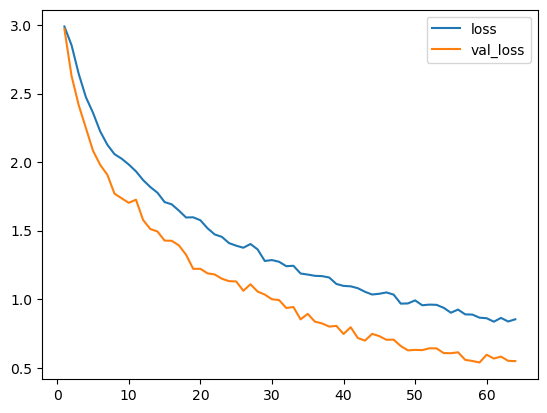

In [93]:
metrics[['loss','val_loss']].plot()

<Axes: >

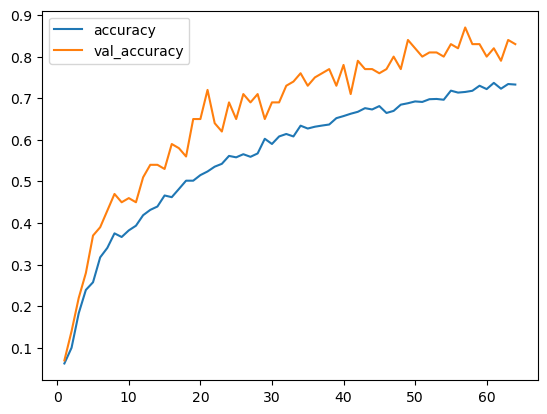

In [95]:
metrics[['accuracy','val_accuracy']].plot()

### Model's performance on test data

In [119]:
y_pred = cnn.predict(test_data)

100/100 [==============================] - 2s 20ms/step


In [121]:
#test_data.reset()

y_true = []
for i in range(len(test_data)):
    y_true.extend(np.argmax(test_data[i][1], axis=1))

y_true = np.array(y_true)

In [123]:
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

In [125]:
print(classification_report(y_true, y_pred_classes, 
                            target_names=test_data.class_indices.keys()))

                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.33      0.80      0.47         5
             ABBOTTS BOOBY       0.80      0.80      0.80         5
ABYSSINIAN GROUND HORNBILL       0.75      0.60      0.67         5
     AFRICAN CROWNED CRANE       0.62      1.00      0.77         5
    AFRICAN EMERALD CUCKOO       1.00      0.60      0.75         5
         AFRICAN FIREFINCH       1.00      1.00      1.00         5
    AFRICAN OYSTER CATCHER       0.75      0.60      0.67         5
     AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
       AFRICAN PYGMY GOOSE       1.00      0.80      0.89         5
                 ALBATROSS       1.00      0.80      0.89         5
            ALBERTS TOWHEE       1.00      0.60      0.75         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      1.00      1.00         5
     ALTAMIRA YELLOWTHROAT       0.83      1.00

### Model's performance on validation data

In [139]:
y_pred_val = cnn.predict(val_data)

100/100 [==============================] - 3s 25ms/step


In [141]:
y_true_val = []
for i in range(len(val_data)):
    y_true_val.extend(np.argmax(val_data[i][1], axis=1))

y_true_val = np.array(y_true_val)

In [143]:
# Convert predictions to class labels
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

In [145]:
print(classification_report(y_true_val, y_pred_val_classes, 
                            target_names=val_data.class_indices.keys()))

                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.45      1.00      0.62         5
             ABBOTTS BOOBY       0.75      0.60      0.67         5
ABYSSINIAN GROUND HORNBILL       0.80      0.80      0.80         5
     AFRICAN CROWNED CRANE       0.83      1.00      0.91         5
    AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
         AFRICAN FIREFINCH       0.83      1.00      0.91         5
    AFRICAN OYSTER CATCHER       1.00      0.80      0.89         5
     AFRICAN PIED HORNBILL       0.56      1.00      0.71         5
       AFRICAN PYGMY GOOSE       1.00      0.80      0.89         5
                 ALBATROSS       0.80      0.80      0.80         5
            ALBERTS TOWHEE       1.00      0.80      0.89         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      0.40      0.57         5
     ALTAMIRA YELLOWTHROAT       0.83      1.00

### Making a prediction on new dataset

In [148]:
y_pred_new = cnn.predict(pred_data)

6/6 [==============================] - 0s 21ms/step


In [164]:
# Convert predictions to class labels
y_pred_new_classes = np.argmax(y_pred_new, axis=1)
y_pred_new_classes

array([3, 3, 3, 3, 3, 1], dtype=int64)

In [ ]:
# Convert classes to keys
train_labels = list(train_data.class_indices.keys())

y_pred_new_classes_labels = list(map(lambda x: train_labels[x], y_pred_new_classes))
y_pred_new_classes_labels

In [ ]:
for idx, file in enumerate(files['images2predict']) :
    image = plt.imread(file) 
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Identified by CNN model as **{y_pred_new_classes_labels[idx]}**')
    plt.show()